# 3_modeling_suto

**Purpose:** State the purpose of the notebook.

**Methodology:** Quickly describe assumptions and processing steps.

**Results:** Describe and comment the most important results.

---

**Suggested next steps**

- [ ] State suggested next steps, based on results obtained in this notebook.

# Setup

## Library import
We import all the required Python libraries

In [1]:
import joblib
import os
from typing import List, Union
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
# from pycaret.regression import *
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

os.chdir('../')
from src.utils.data_describe import breve_descricao, serie_nulos, cardinalidade
os.chdir('./notebooks/')

# Options for pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

warnings.filterwarnings("ignore")

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

### Custom functions

In [2]:
def rfr_feature_selection(
    df: pd.DataFrame, minimal_importance: float = 0.001, lst_columns: Union[str, List] = []
) -> List:
    importance = minimal_importance
    dct_performance = {}
    
    if len(lst_columns) == 0:
        lst_columns = df.columns.tolist()
    
    while len(lst_columns) > 1:
        model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
        model.fit(X_train[lst_columns], y_train.values)
        y_pred = model.predict(X_test[lst_columns])
        dct_performance[len(lst_columns)] = {"features": lst_columns, 'RMSE': mse(y_test, y_pred)**.5}
        lst_columns = df_importance.loc[df_importance['importance']>importance].index.tolist()
        importance += 0.005
        
    return dct_performance

## Parameter definition

We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [3]:
RAW_FOLDER = '../data/raw/'
INTERIM_FOLDER = '../data/interim/'
PROCESSED_FOLDER = '../data/processed/'
MODELS_FOLDER = '../models/'
REPORTS_FOLDER = '../reports/'
RANDOM_STATE = 42


# Data import
We retrieve all the required data for the analysis.

In [4]:
df = pd.read_parquet(INTERIM_FOLDER + 'df_train_interim_01_baseline.pqt')
df_evaluation = df.copy() 
print(f"df_evaluation's shape: {df_evaluation.shape}")

# Importing Kaggle's test dataset.
x_test_kaggle = pd.read_parquet(INTERIM_FOLDER + 'x_test_kaggle_prepared_baseline.pqt')
print(f"x_test_kaggle's shape: {x_test_kaggle.shape}")

df_evaluation's shape: (1460, 19)
x_test_kaggle's shape: (1459, 18)


## Splitting data in training and validation datasets

In [6]:
X = df_evaluation.drop(columns=['SalePrice'])
y = df_evaluation[['SalePrice']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# 1st experiment: Simple linear regression

This 1st experiment has the purpose to set a baseline to our model.

## Modeling and evaluating with the validation data

RMSE: 40198.72


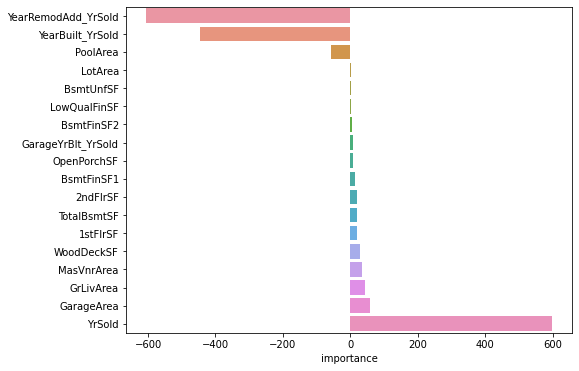

In [7]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

coef_importance = pd.DataFrame(model.coef_[0], index=X_train.columns).sort_values(by=0, ascending=True)
coef_importance.rename(columns={0: 'importance'}, inplace=True)

a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=coef_importance, y=coef_importance.index, x='importance', ax=ax);

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

## Testing the Kaggle's test dataset

In [8]:
x_test_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LotArea              1459 non-null   int64  
 1   MasVnrArea           1459 non-null   float64
 2   BsmtFinSF1           1459 non-null   float64
 3   BsmtFinSF2           1459 non-null   float64
 4   BsmtUnfSF            1459 non-null   float64
 5   TotalBsmtSF          1459 non-null   float64
 6   1stFlrSF             1459 non-null   int64  
 7   2ndFlrSF             1459 non-null   int64  
 8   LowQualFinSF         1459 non-null   int64  
 9   GrLivArea            1459 non-null   int64  
 10  GarageArea           1459 non-null   float64
 11  WoodDeckSF           1459 non-null   int64  
 12  OpenPorchSF          1459 non-null   int64  
 13  PoolArea             1459 non-null   int64  
 14  YrSold               1459 non-null   int64  
 15  YearBuilt_YrSold     1459 non-null 

In [9]:
y_pred_kaggle = model.predict(x_test_kaggle)
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)
y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,88882.905215
836,2297,268186.559189
413,1874,157618.145918
522,1983,202118.136560
1035,2496,248852.367410
614,2075,157944.900049
218,1679,317485.446384
1031,2492,193763.232067
1289,2750,110524.726125
886,2347,198759.393734


In [10]:
y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_baseline_linear_regression.csv', index=False)

# 2nd experiment: Random forest regressor with default hyperparameters
 
This experiment has the purpose to compare the performance between a parametric method and a non-parametric model.

## Modeling and evaluating with the validation data

In [11]:
model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

RMSE: 31725.89


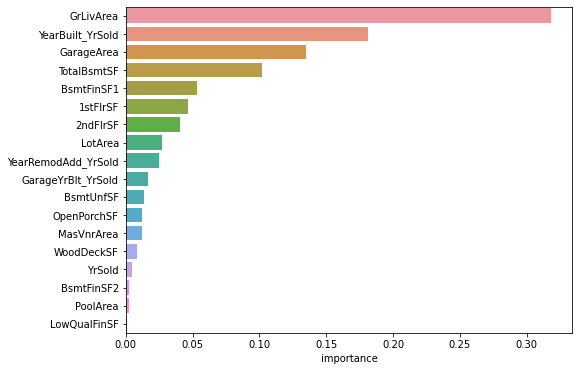

In [12]:
df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

## Testing the Kaggle's test dataset

In [13]:
y_pred_kaggle = model.predict(x_test_kaggle)
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)
y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,101946.000000
836,2297,311331.880000
413,1874,141880.666667
522,1983,201130.600000
1035,2496,224825.800000
614,2075,148259.500000
218,1679,395034.630000
1031,2492,197361.000000
1289,2750,135898.120000
886,2347,207506.060000


In [14]:
y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_baseline_random_forest_default.csv', index=False)

# 3rd experiment: Random forest regressor with grid search

## Grid search

I'll try to follow these steps:

1. Use RandomizedSearchCV in a broader range for each hyperparameter;
2. After find the best candidate in the previous step, search in a smaller area around the point obtained.

### RandomizedSearchCV

In [15]:
hyperparameter_search_space = dict(
    n_estimators=np.arange(200, 1000, 1000).tolist(),
    max_depth=np.arange(int(len(X_train.columns)**.5), int(len(X_train.columns))+1, 2).tolist(),
    min_samples_split=np.arange(2, 20, 2).tolist(),
    min_samples_leaf=np.arange(1, 20, 2).tolist(),
    max_features=['sqrt', 'log2', len(X_train.columns)-2, len(X_train.columns)],
    ccp_alpha=np.arange(0, 0.05, 0.005).tolist(),
)

hyperparameter_search_space

{'n_estimators': [200],
 'max_depth': [4, 6, 8, 10, 12, 14, 16, 18],
 'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18],
 'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
 'max_features': ['sqrt', 'log2', 16, 18],
 'ccp_alpha': [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045]}

In [16]:
model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)

random_grid_search = RandomizedSearchCV(model, hyperparameter_search_space, random_state=RANDOM_STATE, n_iter=50)
search = random_grid_search.fit(X_train, y_train)
search.best_params_

{'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 18,
 'max_depth': 16,
 'ccp_alpha': 0.0}

### Modeling and evaluating with the validation data

In [17]:
model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE, **search.best_params_)
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

RMSE: 31994.30


In [18]:
y_pred_kaggle = model.predict(x_test_kaggle)
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)
y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,101591.283515
836,2297,302812.574188
413,1874,141381.879851
522,1983,201842.053327
1035,2496,237629.387447
614,2075,150311.746399
218,1679,390212.902104
1031,2492,197390.003635
1289,2750,136082.106259
886,2347,210196.614681


In [19]:
model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=16, max_features=18, min_samples_split=8,
                      n_estimators=200, n_jobs=-1, random_state=42)>

In [20]:
y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_baseline_random_forest_random_grid_search.csv', index=False)

### Partial concluision

The hyperparameters obtained by the random search do not reduced the RMSE. So I will not try the grid search for now.

# 4th experiment: Feature selection + Random Forest Regressor

Using the same baseline dataset, remove some of the features with less importance and evaluate the impact in RMSE.

## Getting the feature importance

RMSE: 31725.89


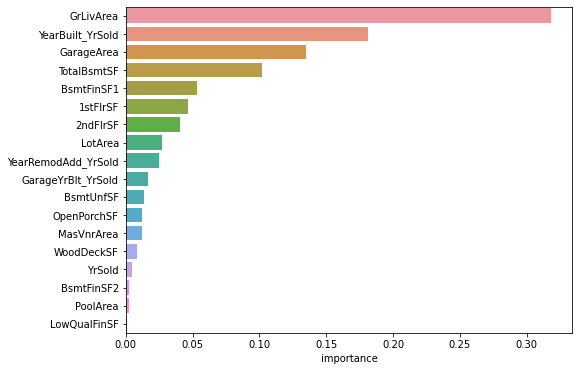

In [21]:
model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

### Evaluating the feature selection through feature importance

I will see the impact of feature selection in the RMSE.

In [22]:
dct_performance = rfr_feature_selection(df=X_train)
pd.DataFrame.from_dict(dct_performance, orient='index').sort_values(by='RMSE', ascending=True)

,features,RMSE
9,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",30325.063697
10,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",30623.545931
13,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",30721.899910
8,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",31046.455787
14,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",31228.334743
18,"[LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, ...",31725.887225
17,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",31923.648801
6,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32416.133314
5,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32513.871299
4,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32708.542754


RMSE: 30623.55


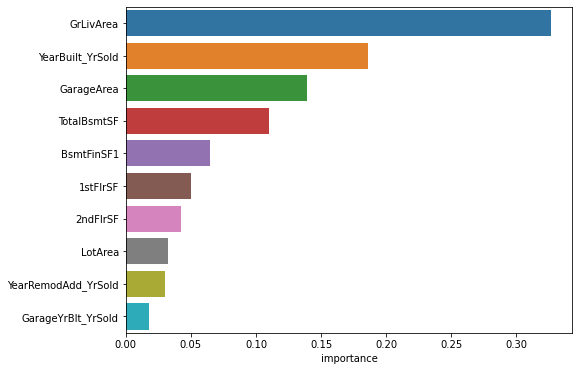

In [23]:
lst_columns = dct_performance[10]['features']

model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train[lst_columns], y_train.values)

y_pred = model.predict(X_test[lst_columns])

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

In [24]:
x_test_kaggle_reduced = x_test_kaggle[lst_columns].copy()

y_pred_kaggle = model.predict(x_test_kaggle_reduced[lst_columns])
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle_reduced.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)
y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,99389.00
836,2297,317451.67
413,1874,142310.00
522,1983,201026.55
1035,2496,223975.59
614,2075,143911.50
218,1679,385395.15
1031,2492,192156.50
1289,2750,135175.25
886,2347,208197.87


In [25]:
y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_baseline_random_forest_random_rfr_feature_selection.csv', index=False)

### Partial conclusion

Even with a lower RMSE for the validation dataset, the score obtained with the test score in Kaggle's leaderboard do not presented a decrease. The strategy must change once again. This time, I'm going to add some categorical attributes in a random forest regressor. 

# 5th experiment: Added binary attributes

## Importing data

In [26]:
df = pd.read_parquet(INTERIM_FOLDER + 'df_train_interim_02_2nd_experiment.pqt')
df_evaluation = df.copy() 
print(f"df_evaluation's shape: {df_evaluation.shape}")

# Importing Kaggle's test dataset.
x_test_kaggle = pd.read_parquet(INTERIM_FOLDER + 'x_test_kaggle_prepared_2nd_experiment.pqt')
print(f"x_test_kaggle's shape: {x_test_kaggle.shape}")

df_evaluation's shape: (1460, 25)
x_test_kaggle's shape: (1459, 24)


### Splitting data

In [27]:
X = df_evaluation.drop(columns=['SalePrice'])
y = df_evaluation[['SalePrice']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Modeling

RMSE: 32042.66


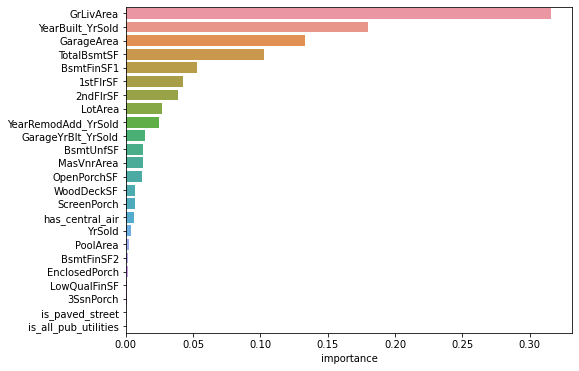

In [28]:
model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

#### Testing different set of predictors

In [29]:
dct_performance = rfr_feature_selection(df=X_train)
pd.DataFrame.from_dict(dct_performance, orient='index').sort_values(by='RMSE', ascending=True)

,features,RMSE
9,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",30325.063697
8,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",31046.455787
13,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",31172.858137
24,"[has_central_air, is_paved_street, is_all_pub_...",32042.661418
16,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32077.270829
20,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32239.141222
6,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32416.133314
5,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32513.871299
4,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32708.542754
7,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",33004.774121


RMSE: 30325.06


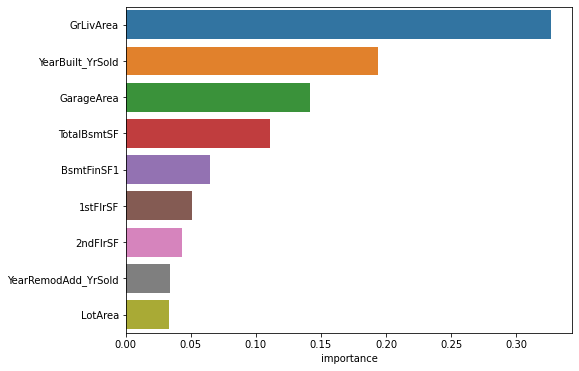

In [31]:
lst_columns = dct_performance[9]['features']

model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train[lst_columns], y_train.values)

y_pred = model.predict(X_test[lst_columns])

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

In [32]:
x_test_kaggle_reduced = x_test_kaggle[lst_columns].copy()

y_pred_kaggle = model.predict(x_test_kaggle_reduced[lst_columns])
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle_reduced.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)
y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,101934.00
836,2297,316040.85
413,1874,142658.00
522,1983,201500.68
1035,2496,224459.80
614,2075,144243.00
218,1679,396445.75
1031,2492,189535.32
1289,2750,137106.25
886,2347,207228.44


In [33]:
y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_2nd_dataset_rfr_feature_selection.csv', index=False)

# 6th experiment: Random forest regression and using floats, integer and binary attributes

## Importing data

In [5]:
X_train = pd.read_parquet(INTERIM_FOLDER + 'X_train_3rd_dataprep.pqt')
X_test = pd.read_parquet(INTERIM_FOLDER + 'X_test_3rd_dataprep.pqt')
y_train = pd.read_parquet(INTERIM_FOLDER + 'y_train_3rd_dataprep.pqt')
y_test = pd.read_parquet(INTERIM_FOLDER + 'y_test_3rd_dataprep.pqt')

x_test_kaggle = pd.read_parquet(INTERIM_FOLDER + 'x_test_kaggle_3rd_dataprep.pqt')

## Modeling and evaluating

RMSE: 28100.11


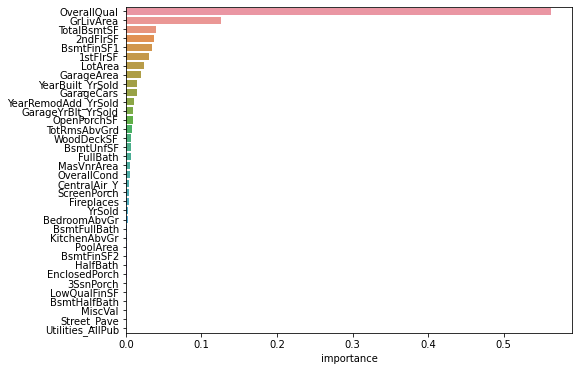

In [6]:
model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

## Testing the kaggle's dataset

In [7]:
y_pred_kaggle = model.predict(x_test_kaggle)
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)

y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_6th_experiment.csv', index=False)

y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,99708.66
836,2297,307046.00
413,1874,139029.60
522,1983,214939.63
1035,2496,217358.49
614,2075,149312.25
218,1679,387210.65
1031,2492,183707.50
1289,2750,135654.25
886,2347,205877.70


## Selecting attributes

In [8]:
lst_selected_atributes = df_importance.loc[df_importance['importance']>0.002].index.tolist()

RMSE: 28079.94


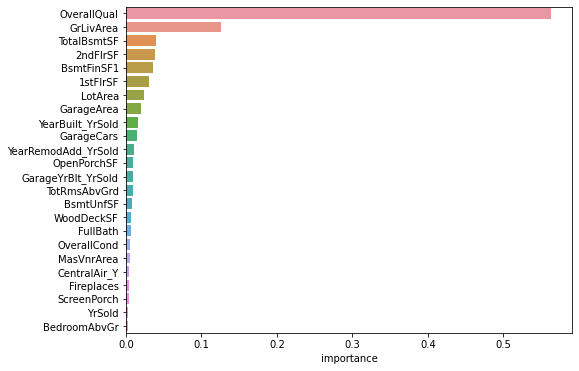

In [9]:
model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X_train[lst_selected_atributes], y_train.values)

y_pred = model.predict(X_test[lst_selected_atributes])

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

## Testing the kaggle's dataset

In [10]:
y_pred_kaggle = model.predict(x_test_kaggle[lst_selected_atributes])
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)

y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_6th_experiment_w_feature_selection.csv', index=False)

y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,100052.49
836,2297,306766.55
413,1874,139535.10
522,1983,217120.59
1035,2496,218083.06
614,2075,148388.50
218,1679,388813.75
1031,2492,185941.70
1289,2750,135140.75
886,2347,206286.65


# 7th experiment: LightGBM and using floats, integer and binary attributes

## 9.1  Importing data

In [23]:
X_train = pd.read_parquet(INTERIM_FOLDER + 'X_train_3rd_dataprep.pqt')
X_test = pd.read_parquet(INTERIM_FOLDER + 'X_test_3rd_dataprep.pqt')
y_train = pd.read_parquet(INTERIM_FOLDER + 'y_train_3rd_dataprep.pqt')
y_test = pd.read_parquet(INTERIM_FOLDER + 'y_test_3rd_dataprep.pqt')

df_train = pd.concat([X_train, y_train], axis=1)
df_temp = pd.concat([X_test, y_test], axis=1)
df_train = pd.concat([df_train, df_temp], axis=0)

# Joining the train and validation datasets to use in pycaret.
print(f"""
X_train: {X_train.shape}
X_test: {X_test.shape}
y_train: {y_train.shape}
y_test: {y_test.shape}
df_train: {df_train.shape}""")

x_test_kaggle = pd.read_parquet(INTERIM_FOLDER + 'x_test_kaggle_3rd_dataprep.pqt')


X_train: (1168, 36)
X_test: (292, 36)
y_train: (1168, 1)
y_test: (292, 1)
df_train: (1460, 37)


## Modeling and evaluating

RMSE: 29849.17


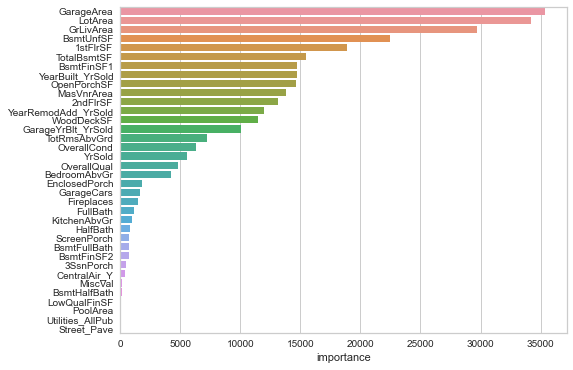

In [14]:
model = lgb.LGBMRegressor(n_estimators=10000, n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_name_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

## Testing the kaggle's dataset

In [15]:
y_pred_kaggle = model.predict(x_test_kaggle)
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)

y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_7th_experiment.csv', index=False)

y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,98985.562365
836,2297,297859.473277
413,1874,132946.364151
522,1983,208639.438794
1035,2496,244255.565589
614,2075,145061.007678
218,1679,422863.713014
1031,2492,196240.439463
1289,2750,141561.796196
886,2347,214021.824851


## Modeling and evaluating with feature selection

RMSE: 29860.22


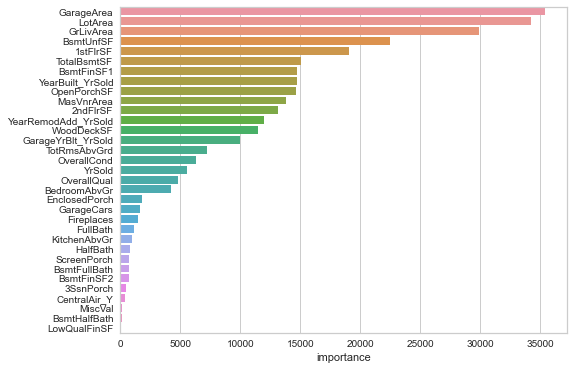

In [16]:
lst_selected_atributes = df_importance.loc[df_importance['importance']>0.002].index.tolist()

model = lgb.LGBMRegressor(n_estimators=10000, n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X_train[lst_selected_atributes], y_train.values)

y_pred = model.predict(X_test[lst_selected_atributes])

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_name_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

## Testing the kaggle's dataset

In [17]:
y_pred_kaggle = model.predict(x_test_kaggle[lst_selected_atributes])
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)

y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_7th_experiment_w_feature_selection.csv', index=False)

y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,98985.562365
836,2297,297859.473277
413,1874,132946.364151
522,1983,208639.438794
1035,2496,244255.565589
614,2075,145061.007678
218,1679,422863.713014
1031,2492,196240.439463
1289,2750,141561.796196
886,2347,214021.824851


## Modeling with gridsearch

### Random grid search

In [18]:
hyperparameter_search_space = dict(
    n_estimators=np.arange(500, 1500, 250).tolist(),
    learning_rate=np.arange(0.0, 0.1, 0.025).tolist(),
    max_depth=np.arange(int(len(X_train.columns)**.5), int(len(X_train.columns))+1, 2).tolist(),
    reg_alpha=np.arange(0.0, 0.5, 0.1).tolist()
)

hyperparameter_search_space

model = lgb.LGBMRegressor(n_jobs=-1, random_state=RANDOM_STATE)

random_grid_search = RandomizedSearchCV(
    model, hyperparameter_search_space, scoring='neg_mean_squared_error', random_state=RANDOM_STATE, n_iter=100
)

search = random_grid_search.fit(X_train, y_train)
print(f"Random grid search's best params: {search.best_params_}")

Random grid search's best params: {'reg_alpha': 0.2, 'n_estimators': 500, 'max_depth': 18, 'learning_rate': 0.025}


### Grid search around the n-dimensional point found in the previous step

In [19]:
dct_params = {}

for key, item in search.best_params_.items():
    print(key, item)
    if key in ['n_estimators', 'max_depth']:
        dct_params[key] = np.arange(int(item/1.5), int(item*1.5), int(0.25*item)).tolist()
    else:
        dct_params[key] = np.arange(item/1.5, item*1.5, 0.25*item).tolist()
    
dct_params

reg_alpha 0.2
n_estimators 500
max_depth 18
learning_rate 0.025


{'reg_alpha': [0.13333333333333333,
  0.18333333333333335,
  0.23333333333333336,
  0.2833333333333334],
 'n_estimators': [333, 458, 583, 708],
 'max_depth': [12, 16, 20, 24],
 'learning_rate': [0.016666666666666666,
  0.02291666666666667,
  0.02916666666666667,
  0.03541666666666667]}

In [20]:
grid_search = GridSearchCV(
    model, dct_params, scoring='neg_mean_squared_error'
)

search = grid_search.fit(X_train, y_train)
print(f"Grid search's best params: {search.best_params_}")

Grid search's best params: {'learning_rate': 0.03541666666666667, 'max_depth': 16, 'n_estimators': 333, 'reg_alpha': 0.2833333333333334}


### Modeling and evaluating

RMSE: 29788.46


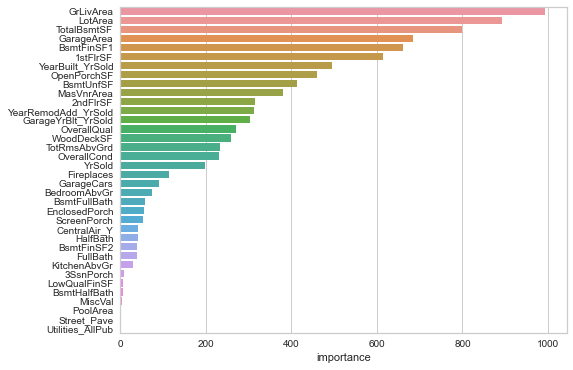

In [22]:
try:
    best_params = search.best_params_
except:
    best_params = {
        'learning_rate': 0.03541666666666667, 'max_depth': 16, 'n_estimators': 333, 'reg_alpha': 0.2833333333333334
    }

model = lgb.LGBMRegressor(**best_params, n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X_train, y_train.values)

model_filename = 'model_7th_experiment_7th_experiment_gridsearch.sav'
joblib.dump(model, MODELS_FOLDER + model_filename)

loaded_model = joblib.load(MODELS_FOLDER + model_filename)

y_pred = loaded_model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_name_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

### Modeling again but adding the validation data into the training data

In [24]:
try:
    best_params = search.best_params_
except:
    best_params = {
        'learning_rate': 0.03541666666666667, 'max_depth': 16, 'n_estimators': 333, 'reg_alpha': 0.2833333333333334
    }

model = lgb.LGBMRegressor(**best_params, n_jobs=-1, random_state=RANDOM_STATE)
model.fit(df_train.drop(columns=['SalePrice']), df_train['SalePrice'].values)

model_filename = 'model_7th_experiment_7th_experiment_gridsearch_more_data.sav'
joblib.dump(model, MODELS_FOLDER + model_filename)

loaded_model = joblib.load(MODELS_FOLDER + model_filename)

## Testing the kaggle's dataset

In [25]:
loaded_model = joblib.load(MODELS_FOLDER + model_filename)

y_pred_kaggle = loaded_model.predict(x_test_kaggle)
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)

y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_7th_experiment_gridsearch.csv', index=False)

y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,89778.741697
836,2297,302599.230998
413,1874,141968.444317
522,1983,208047.548789
1035,2496,245631.250539
614,2075,148021.660049
218,1679,416822.433053
1031,2492,193254.444893
1289,2750,143316.894132
886,2347,203818.173272


## Modeling with grid search results and feature selection

RMSE: 29788.70


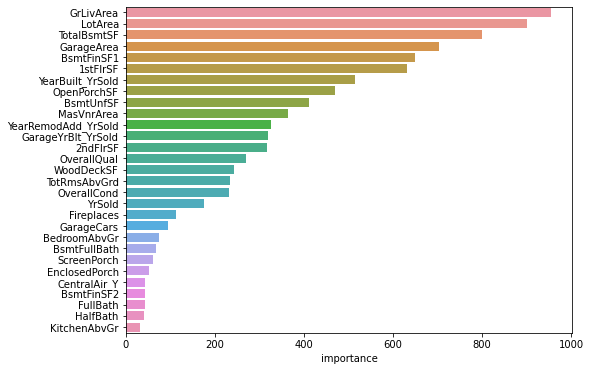

In [101]:
lst_selected_atributes = df_importance.loc[df_importance['importance']>10].index.tolist()

model = lgb.LGBMRegressor(**search.best_params_, n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X_train[lst_selected_atributes], y_train.values)

y_pred = model.predict(X_test[lst_selected_atributes])

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_name_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

In [103]:
y_pred_kaggle = model.predict(x_test_kaggle[lst_selected_atributes])
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)

y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_7th_experiment_gridsearch_feature_selection.csv', index=False)

y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,97520.903723
836,2297,299047.592633
413,1874,139018.043616
522,1983,208782.640664
1035,2496,249075.477452
614,2075,147545.272336
218,1679,400980.721852
1031,2492,187884.952148
1289,2750,148585.842630
886,2347,210435.898778


# Testing other models with Pycaret

## Importing data

In [4]:
X_train = pd.read_parquet(INTERIM_FOLDER + 'X_train_3rd_dataprep.pqt')
X_test = pd.read_parquet(INTERIM_FOLDER + 'X_test_3rd_dataprep.pqt')
y_train = pd.read_parquet(INTERIM_FOLDER + 'y_train_3rd_dataprep.pqt')
y_test = pd.read_parquet(INTERIM_FOLDER + 'y_test_3rd_dataprep.pqt')

df_train = pd.concat([X_train, y_train], axis=1)
df_temp = pd.concat([X_test, y_test], axis=1)
df_train = pd.concat([df_train, df_temp], axis=0)

# Joining the train and validation datasets to use in pycaret.
print(f"""
X_train: {X_train.shape}
X_test: {X_test.shape}
y_train: {y_train.shape}
y_test: {y_test.shape}
df_train: {df_train.shape}""")

x_test_kaggle = pd.read_parquet(INTERIM_FOLDER + 'x_test_kaggle_3rd_dataprep.pqt')


X_train: (1168, 36)
X_test: (292, 36)
y_train: (1168, 1)
y_test: (292, 1)
df_train: (1460, 37)


In [11]:
exp_reg = setup(data=df_train, target='SalePrice', train_size=0.9)

,Description,Value
0,session_id,7702
1,Target,SalePrice
2,Original Data,"(1460, 37)"
3,Missing Values,False
4,Numeric Features,21
5,Categorical Features,15
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1314, 138)"


In [28]:
best = compare_models();

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,17990.9150,795773427.2580,27888.0044,0.8740,0.1456,0.1063,0.1150
lightgbm,Light Gradient Boosting Machine,18040.2651,835277786.1085,28691.5013,0.8686,0.1448,0.1052,0.0320
rf,Random Forest Regressor,18468.1801,845865865.7120,29028.9726,0.8646,0.1526,0.1099,0.2590
et,Extra Trees Regressor,20531.1825,968637666.8820,31016.9828,0.8450,0.1632,0.1192,0.2400
llar,Lasso Least Angle Regression,18339.9246,1054356505.3302,30115.3314,0.8388,0.1579,0.1103,0.0110
lasso,Lasso Regression,18470.9170,1072312209.9145,30345.5994,0.8360,0.1583,0.1112,0.0570
ridge,Ridge Regression,18677.7573,1126252023.4596,31335.1482,0.8283,0.1556,0.1103,0.0070
lr,Linear Regression,18736.1766,1162006667.3430,31721.4391,0.8230,0.1801,0.1126,0.0090
omp,Orthogonal Matching Pursuit,20031.7531,1181232263.7378,31939.4635,0.8195,0.1640,0.1217,0.0060
ada,AdaBoost Regressor,25387.7912,1358577513.2004,36467.2813,0.7872,0.2085,0.1682,0.0800


In [33]:
best

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=7702, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# 8th experiment: Gradient Boosting Regressor

## Importing data

In [6]:
X_train = pd.read_parquet(INTERIM_FOLDER + 'X_train_3rd_dataprep.pqt')
X_test = pd.read_parquet(INTERIM_FOLDER + 'X_test_3rd_dataprep.pqt')
y_train = pd.read_parquet(INTERIM_FOLDER + 'y_train_3rd_dataprep.pqt')
y_test = pd.read_parquet(INTERIM_FOLDER + 'y_test_3rd_dataprep.pqt')

df_train = pd.concat([X_train, y_train], axis=1)
df_temp = pd.concat([X_test, y_test], axis=1)
df_train = pd.concat([df_train, df_temp], axis=0)

x_test_kaggle = pd.read_parquet(INTERIM_FOLDER + 'x_test_kaggle_3rd_dataprep.pqt')

## Modeling and evaluation

RMSE: 30547.57


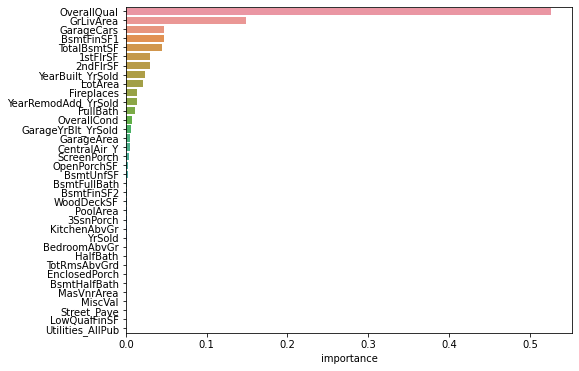

In [24]:
model = GradientBoostingRegressor(random_state=RANDOM_STATE)
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

In [25]:
y_pred_kaggle = model.predict(x_test_kaggle)
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)

y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_8th_experiment.csv', index=False)

y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,89660.648392
836,2297,314057.324786
413,1874,145223.313444
522,1983,223795.126394
1035,2496,246998.848348
614,2075,148300.241085
218,1679,359084.519096
1031,2492,174143.543136
1289,2750,144833.081490
886,2347,201847.795003


# 9th experiment: GB Regressor using the 4th data prep

In [14]:
X_train = pd.read_parquet(INTERIM_FOLDER + 'X_train_4th_dataprep.pqt')
X_test = pd.read_parquet(INTERIM_FOLDER + 'X_test_4th_dataprep.pqt')
y_train = pd.read_parquet(INTERIM_FOLDER + 'y_train_4th_dataprep.pqt')
y_test = pd.read_parquet(INTERIM_FOLDER + 'y_test_4th_dataprep.pqt')

df_train = pd.concat([X_train, y_train], axis=1)
df_temp = pd.concat([X_test, y_test], axis=1)
df_train = pd.concat([df_train, df_temp], axis=0)

x_test_kaggle = pd.read_parquet(INTERIM_FOLDER + 'x_test_kaggle_4th_dataprep.pqt')

## Modeling and evaluation

RMSE: 28294.74


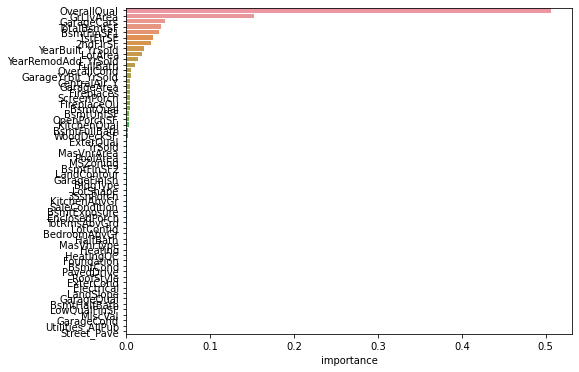

In [52]:
model = GradientBoostingRegressor(n_estimators=1000, random_state=RANDOM_STATE)
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

## Adding validation dataset to training the model

In [53]:
model = GradientBoostingRegressor(n_estimators=1000, random_state=RANDOM_STATE)
model.fit(df_train.drop(columns=['SalePrice']), df_train['SalePrice'].values)

GradientBoostingRegressor(n_estimators=1000, random_state=42)

In [54]:
y_pred_kaggle = model.predict(x_test_kaggle)
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)

y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_9th_experiment.csv', index=False)

y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,79508.494407
836,2297,309673.711385
413,1874,141424.264224
522,1983,214132.509232
1035,2496,264207.714498
614,2075,144706.614204
218,1679,372614.150957
1031,2492,180113.616625
1289,2750,146363.014393
886,2347,199147.849361


# 10th experiment: GB Regressor using the 4th data prep and grid search

In [5]:
X_train = pd.read_parquet(INTERIM_FOLDER + 'X_train_4th_dataprep.pqt')
X_test = pd.read_parquet(INTERIM_FOLDER + 'X_test_4th_dataprep.pqt')
y_train = pd.read_parquet(INTERIM_FOLDER + 'y_train_4th_dataprep.pqt')
y_test = pd.read_parquet(INTERIM_FOLDER + 'y_test_4th_dataprep.pqt')

df_train = pd.concat([X_train, y_train], axis=1)
df_temp = pd.concat([X_test, y_test], axis=1)
df_train = pd.concat([df_train, df_temp], axis=0)

x_test_kaggle = pd.read_parquet(INTERIM_FOLDER + 'x_test_kaggle_4th_dataprep.pqt')

## Modeling with gridsearch

### Random grid search

In [40]:
hyperparameter_search_space = dict(
    n_estimators=np.arange(500, 1500, 250).tolist(),
    learning_rate=np.arange(0.0, 0.1, 0.025).tolist(),
    max_depth=np.arange(int(len(X_train.columns)**.5), int(len(X_train.columns))+1, 10).tolist(),
    alpha=np.arange(0.0, 0.5, 0.1).tolist()
)

model = GradientBoostingRegressor(random_state=RANDOM_STATE)

random_grid_search = RandomizedSearchCV(
    model, hyperparameter_search_space, scoring='neg_mean_squared_error', random_state=RANDOM_STATE, n_iter=100, n_jobs=-1
)

search = random_grid_search.fit(X_train, y_train)
print(f"Random grid search's best params: {search.best_params_}")

Random grid search's best params: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.025, 'alpha': 0.2}


### Grid search around the n-dimensional point found in the previous step

In [43]:
dct_params = {}

for key, item in search.best_params_.items():
    print(key, item)
    if key in ['n_estimators', 'max_depth']:
        dct_params[key] = np.arange(int(item/1.5), int(item*1.5), int(0.25*item)).tolist()
    else:
        dct_params[key] = np.arange(item/1.5, item*1.5, 0.25*item).tolist()
    
dct_params

n_estimators 1000
max_depth 7
learning_rate 0.025
alpha 0.2


{'n_estimators': [666, 916, 1166, 1416],
 'max_depth': [4, 5, 6, 7, 8, 9],
 'learning_rate': [0.016666666666666666,
  0.02291666666666667,
  0.02916666666666667,
  0.03541666666666667],
 'alpha': [0.13333333333333333,
  0.18333333333333335,
  0.23333333333333336,
  0.2833333333333334]}

In [44]:
grid_search = GridSearchCV(
    model, dct_params, scoring='neg_mean_squared_error', n_jobs=-1
)

search = grid_search.fit(X_train, y_train)
print(f"Grid search's best params: {search.best_params_}")

Grid search's best params: {'alpha': 0.13333333333333333, 'learning_rate': 0.02916666666666667, 'max_depth': 4, 'n_estimators': 1416}


## Modeling and evaluation

RMSE: 27344.52


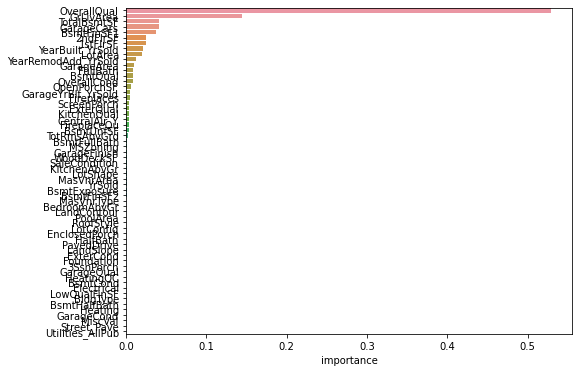

In [28]:
try:
    best_params = search.best_params_
except:
    best_params = {'alpha': 0.13333333333333333, 'learning_rate': 0.02916666666666667, 'max_depth': 4, 'n_estimators': 1416}

model = GradientBoostingRegressor(**best_params, random_state=RANDOM_STATE)
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

## Adding validation dataset to training the model

In [29]:
model = GradientBoostingRegressor(**best_params, random_state=RANDOM_STATE)
model.fit(df_train.drop(columns=['SalePrice']), df_train['SalePrice'].values)

GradientBoostingRegressor(alpha=0.13333333333333333,
                          learning_rate=0.02916666666666667, max_depth=4,
                          n_estimators=1416, random_state=42)

In [30]:
y_pred_kaggle = model.predict(x_test_kaggle)
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)

y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_10th_experiment.csv', index=False)

y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,86515.446888
836,2297,297384.053416
413,1874,140905.094056
522,1983,211958.355803
1035,2496,243798.148820
614,2075,148990.749881
218,1679,385877.199649
1031,2492,174293.113882
1289,2750,144487.262684
886,2347,199500.704318
